In [1]:
library(LogConcDEAD)
library(cubature)
library(MASS)
library(pracma)
library(mvtnorm)

Warning message:
“no DISPLAY variable so Tk is not available”


In [4]:
# ?cov.wt

In [8]:
# princomp

In [5]:
## Generates/gets pre-processed data to be worked with. This should be modified
## according to the desired application and data. Creates global variable 
## pre_Data, which is a matrix whose rows represent each data point.
get_data <- function(d,n) {
  covariance_Z <- matrix(0, ncol = d, nrow = d)
  diag(covariance_Z) <- c(d:1)
  print("Diagonal covariance: ")
  print(covariance_Z)
  W <- randortho(d, type="orthonormal")
  covariance_X <- t(W) %*% covariance_Z %*% W
  pre_data <- mvrnorm(n, mu=rep_len(0,d), Sigma=covariance_X)
  my_output <- list("n"=n, "d"=d, "covariance_Z"=covariance_Z, "covariance_X"=covariance_X, "W"=W, "pre_data"=pre_data)
  return(my_output)
}

In [51]:
print(rep_len(0,3))

[1] 0 0 0


[1] "Diagonal covariance: "
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,]   10    0    0    0    0    0    0    0    0     0
 [2,]    0    9    0    0    0    0    0    0    0     0
 [3,]    0    0    8    0    0    0    0    0    0     0
 [4,]    0    0    0    7    0    0    0    0    0     0
 [5,]    0    0    0    0    6    0    0    0    0     0
 [6,]    0    0    0    0    0    5    0    0    0     0
 [7,]    0    0    0    0    0    0    4    0    0     0
 [8,]    0    0    0    0    0    0    0    3    0     0
 [9,]    0    0    0    0    0    0    0    0    2     0
[10,]    0    0    0    0    0    0    0    0    0     1


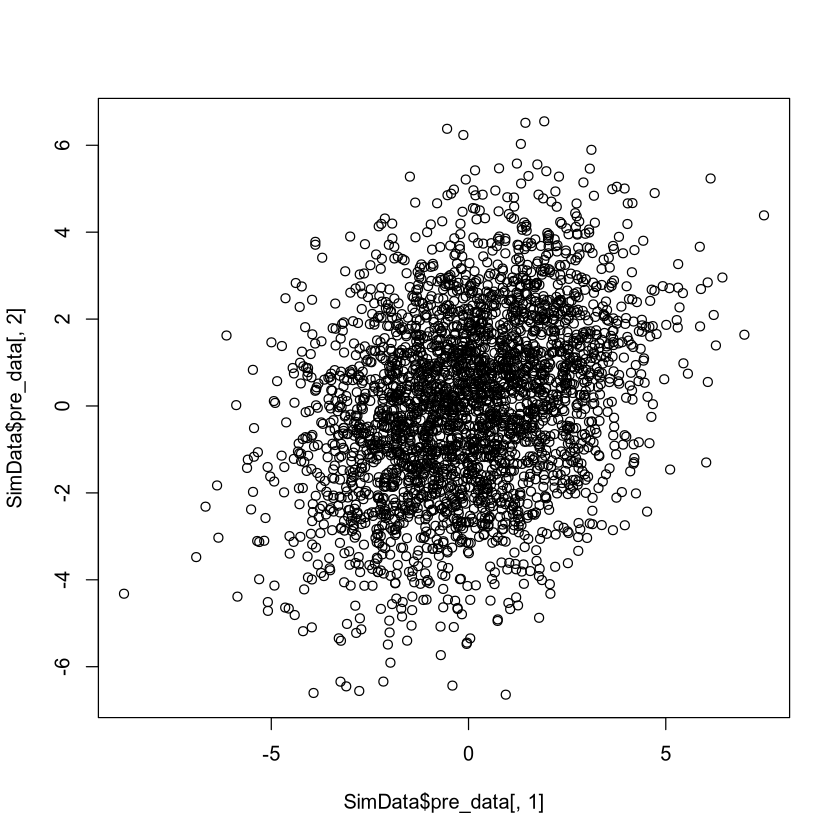

In [50]:
d = 10
n = 3000
SimData = get_data(d, n)
plot(x=SimData$pre_data[,1], y=SimData$pre_data[,2])

In [14]:
SimData$covariance_Z

10,0,0,0,0,0,0,0,0,0
0,9,0,0,0,0,0,0,0,0
0,0,8,0,0,0,0,0,0,0
0,0,0,7,0,0,0,0,0,0
0,0,0,0,6,0,0,0,0,0
0,0,0,0,0,5,0,0,0,0
0,0,0,0,0,0,4,0,0,0
0,0,0,0,0,0,0,3,0,0
0,0,0,0,0,0,0,0,2,0
0,0,0,0,0,0,0,0,0,1


In [15]:
## Randomizes and splits the observations into two sets, with fraction r 
## (0 <= r <= 1) of them going into the first set. Must run 
## get_Data first or else error. Creates global variables data_1 and data_2.
randomize_and_split <- function(SimData, r) {
  num_samples_1 <- floor(r * SimData$n)
  num_samples_2 <- SimData$n - num_samples_1
  randomized_data = SimData$pre_data[sample(SimData$n),]
  data_1 <- randomized_data[1:num_samples_1,]
  data_2 <- randomized_data[(num_samples_1+1):SimData$n,]
  return(list("data_cov_estimation"=data_1, "data_marginal_estimation"=data_2, 
              "n_cov_estimation"=num_samples_1, "n_marginal_estimation"=num_samples_2))
}

In [17]:
tst = c(1:10)
# tst = matrix(tst, nrow=1)
t(t(SimData$covariance_Z) - tst)

9,-2,-3,-4,-5,-6,-7,-8,-9,-10
-1,7,-3,-4,-5,-6,-7,-8,-9,-10
-1,-2,5,-4,-5,-6,-7,-8,-9,-10
-1,-2,-3,3,-5,-6,-7,-8,-9,-10
-1,-2,-3,-4,1,-6,-7,-8,-9,-10
-1,-2,-3,-4,-5,-1,-7,-8,-9,-10
-1,-2,-3,-4,-5,-6,-3,-8,-9,-10
-1,-2,-3,-4,-5,-6,-7,-5,-9,-10
-1,-2,-3,-4,-5,-6,-7,-8,-7,-10
-1,-2,-3,-4,-5,-6,-7,-8,-9,-9


In [21]:

## Generates the density estimate using the algorithm above, 
## based on the two sets of data from randomize_and_split (must run 
## randomize_and_split first or else error).
generate_estimator <- function(SimData, SplitData, plotting=FALSE) {
  W_hat <- t(prcomp(SplitData$data_cov_estimation, center=FALSE, scale=FALSE)$rotation)
  unmixed_obs <- SplitData$data_marginal_estimation %*% t(W_hat)
  marginals <- list()
  print("PCA done!")
  for (i in 1:SimData$d) {
    print("Marginal: ")
    print(i)
    out1 <- mlelcd(unmixed_obs[,i])
    if (plotting){
        plot(out1)
    }
    marginals[[i]] <- out1
  }
  return(list("W_hat"=W_hat, "marginals"=marginals))
}

# INCOMPLETE!
generate_weighted_estimator <- function(SimData, weights_vec, r=0.9, center=TRUE, plotting=FALSE) {
    
    SplitData <- randomize_and_split(SimData, r)
    weights_vec_renormalized <- weights_vec/(sum(weights_vec)*SplitData$n_cov_estimation)
    weighted_cov_compute <- cov.wt(x=SplitData$data_cov_estimation, wt=weights_vec, center=center, method="ML")
    # weighted_emp_cov_mat <- cov_compute$cov
    # weighted_emp_mean <- cov_compute$center

    W_hat <- t(princomp(covmat=weighted_cov_compute$cov, fix_sign=TRUE)$loadings)
    unmixed_obs <- t(W_hat %*% (t(SplitData$data_marginal_estimation) - weighted_cov_compute$center))
    print("PCA done!")
    
    marginals <- list()
    
    for (i in 1:SimData$d) {
        print("Marginal: ")
        print(i)
        out1 <- mlelcd(unmixed_obs[,i])
        if (plotting){
            plot(out1)
        }
        marginals[[i]] <- out1
    }
    return(list("W_hat"=W_hat, "marginals"=marginals, "centers"=weighted_cov_compute$center, 
                "renormalized_weights"=weights_vec_renormalized))
}
    
# Evaluates the estimator most recently generated in generate_estimator at the 
# vector x in R^d (must run generate_estimator beforehand or else error).

evaluate_estimator <- function(x, my_estimator) {
  result = 1
  for (i in 1:dimension) {
    result = result * dlcd(W_hat[i,] %*% x, my_estimator$marginals[[i]])
  }
  return(result)
}

evaluate_estimator_vectorized <- function(X_mat, my_estimator){
    # X_mat must be organized such that each row is a point in R^d
    d <- NCOL(X_mat)
    n_eval <- NROW(X_mat)
    
    Z_mat_hat = X_mat %*% t(my_estimator$W_hat)
    
    result = rep(1.0, n_eval)
    for (dind in 1:d){
        result = result * dlcd(matrix(Z_mat_hat[,dind], ncol = 1), my_estimator$marginals[[dind]])
    }
    return(result)
}


# mlelcd(x)

In [ ]:
# # HOW TO DISTRIBUTE WEIGHTS???
# my_estimator <- generate_weighted_estimator(SimData, weights_vec=rep(1,n), plotting = FALSE)

In [22]:
## Evaluates the pdf of the Gaussian from get_gaussian_test_data at the point x.
gaussian_test_data_pdf <- function(x, d, covariance_Z, W) {
  Kmat_Z <- matrix(0, ncol = d, nrow = d)
  diag(Kmat_Z) <- 1/diag(covariance_Z)
  Kmat_X = t(W) %*% Kmat_Z %*% W
  return(prod(diag((2*pi)*covariance_Z))^(-1/2) * exp(-(1/2)*(t(x)%*% Kmat_X %*% x)))
}

test_pdf_vectorized <- function(X_mat, SimData){
    # X_mat must be organized such that each row is a point in R^d
    my_mean = rep(0, SimData$d)
    return(dmvnorm(X_mat, my_mean, SimData$covariance_X))
}


In [51]:
r <- 0.90
SplitData <- randomize_and_split(SimData, r)
my_estimator <- generate_estimator(SimData, SplitData, plotting = FALSE)

[1] "PCA done!"
[1] "Marginal: "
[1] 1
[1] "Marginal: "
[1] 2
[1] "Marginal: "
[1] 3
[1] "Marginal: "
[1] 4
[1] "Marginal: "
[1] 5
[1] "Marginal: "
[1] 6
[1] "Marginal: "
[1] 7
[1] "Marginal: "
[1] 8
[1] "Marginal: "
[1] 9
[1] "Marginal: "
[1] 10


In [52]:
my_estimator$marginals

[[1]]

 Log MLE at observations: 
  [1] -2.039542 -2.243815 -2.227640 -2.180002 -2.262505 -2.064263 -2.076742
  [8] -3.608738 -3.721044 -2.343607 -2.071254 -2.151895 -3.776933 -3.574429
 [15] -2.221680 -2.144795 -2.086126 -2.345608 -2.347221 -2.218622 -2.040569
 [22] -2.057090 -2.067527 -2.062258 -2.072892 -2.483476 -2.900215 -2.114851
 [29] -2.049760 -2.064880 -2.134652 -2.220752 -2.282147 -2.370965 -2.713835
 [36] -2.093938 -2.087717 -3.614001 -2.050487 -2.326446 -2.070249 -3.152148
 [43] -2.041069 -2.060791 -2.050423 -2.155718 -2.035462 -2.584822 -2.076658
 [50] -2.826448 -3.220616 -2.059360 -2.325968 -2.721940 -2.066766 -2.851373
 [57] -2.651662 -2.250404 -2.179350 -2.248915 -2.080642 -2.259882 -2.345924
 [64] -3.820518 -2.776867 -3.957361 -2.546889 -2.136503 -2.534802 -2.630735
 [71] -6.008741 -2.263775 -2.924672 -3.174874 -2.367290 -2.078380 -2.554366
 [78] -4.124076 -2.064836 -4.713583 -3.439500 -2.203690 -2.765915 -2.569139
 [85] -2.254220 -4.359762 -2.060226 -2.109836 -2.08047

In [74]:
my_estimator$marginals[[10]]$NumberOfEvaluations

[1] 1137 3529 1138

PC1,-0.9925558862,0.1106639961,-0.041568396,0.023663479,3.021054e-05,0.008113576,0.012488413,-0.005074761,-0.0070374814,-0.0011533317
PC2,-0.1056252968,-0.9854110823,-0.122105855,-0.042162115,-9.078475e-03,-0.013788635,0.026861008,0.009512722,0.0057570132,0.0017656787
PC3,-0.0566713657,-0.1081624241,0.978043140,-0.151517508,6.070885e-02,-0.037558927,0.018900872,0.001494977,-0.0064159643,0.0081502563
PC4,-0.0104073670,0.0620846823,-0.145326430,-0.986548090,-3.412143e-02,-0.014281371,0.011833867,-0.005784355,-0.0072866178,0.0067416743
PC5,-0.0028872229,-0.0007687734,0.066335632,0.024037016,-9.966325e-01,0.004039777,-0.038711307,0.001467720,0.0148093146,-0.0003945096
PC6,0.0035984867,-0.0182993819,0.033567116,-0.021524060,7.362000e-03,0.998107964,-0.031291369,0.009194055,0.0245014116,-0.0111553013
PC7,-0.0163922844,-0.0260354077,0.009424620,-0.015604775,3.892850e-02,-0.032503634,-0.997881073,-0.019434960,0.0006541556,-0.0021027930
PC8,-0.0045180778,0.0102875382,-0.001518619,-0.005237295,2.293474e-03,-0.010188558,-0.019165825,0.999403732,0.0230726469,0.0052397819
PC9,0.0067564233,-0.0064789480,-0.003774455,0.007358614,-1.469809e-02,0.024341477,-0.002545059,0.023496006,-0.9991591801,-0.0125630461
PC10,0.0003131755,-0.0019364801,0.006444311,-0.007845769,6.747051e-04,-0.011865283,0.002661648,0.004876090,0.0123123570,-0.9997846627


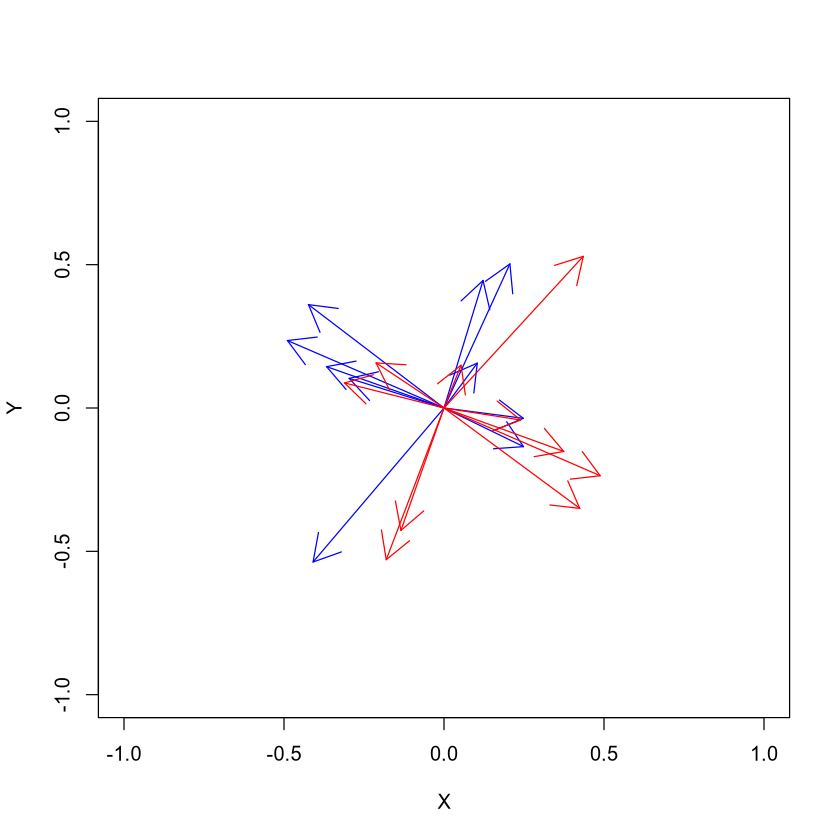

In [39]:
W = SimData$W
W_hat = my_estimator$W_hat
plot(NULL, xlim=c(-1,1), ylim=c(-1,1), xlab="X", ylab="Y")
arrows(rep(0,d), rep(0,d), W[,1], W[,2], col="blue")
arrows(rep(0,d), rep(0,d), W_hat[,1], W_hat[,2], col="red")
W_hat %*% t(W)

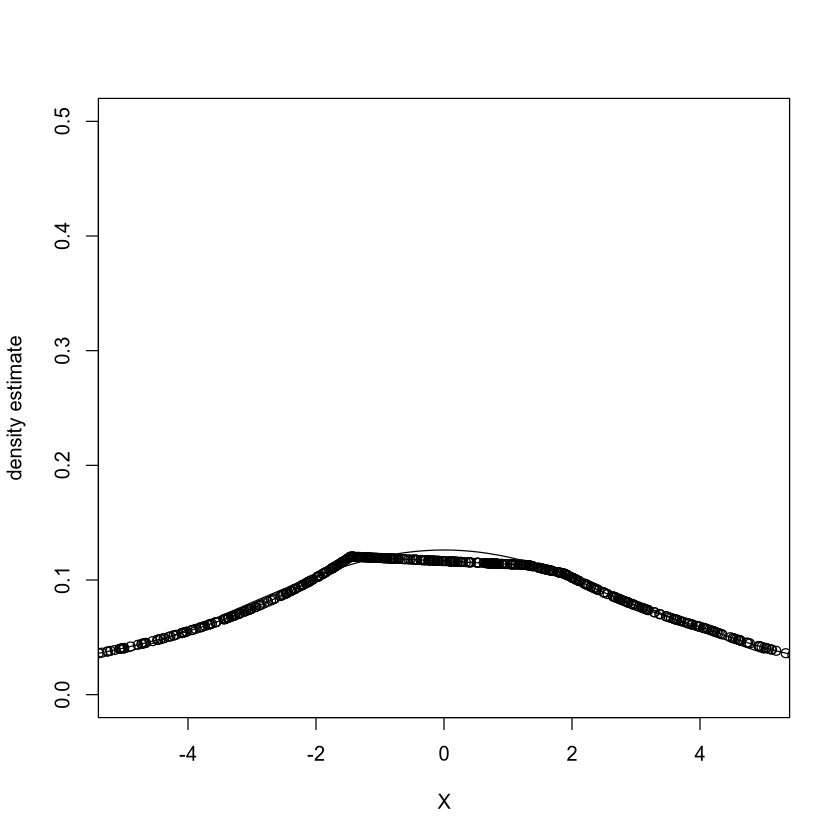

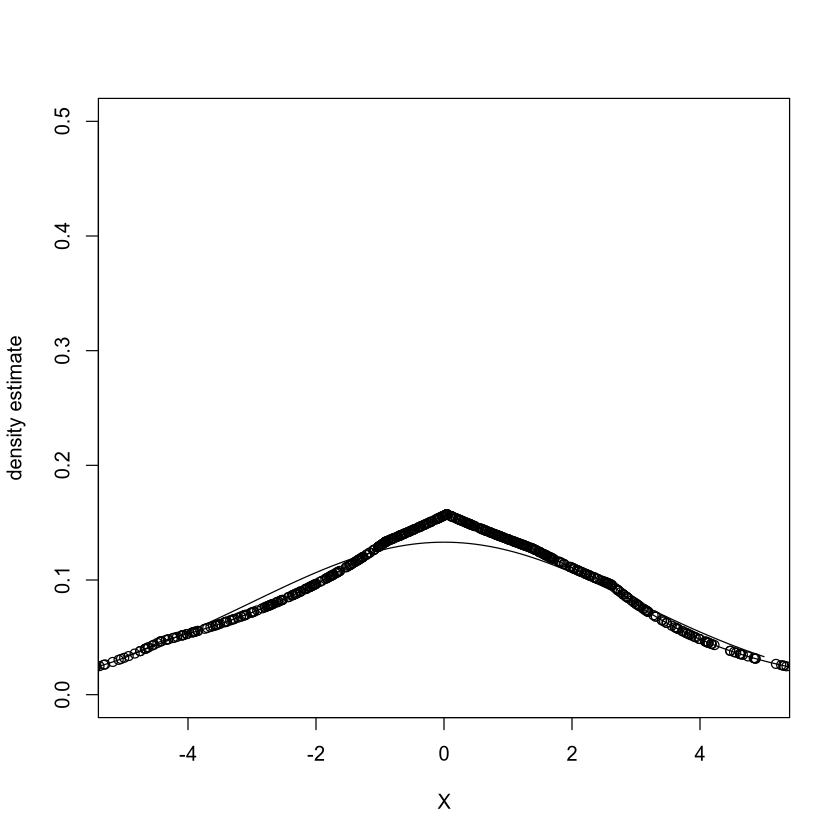

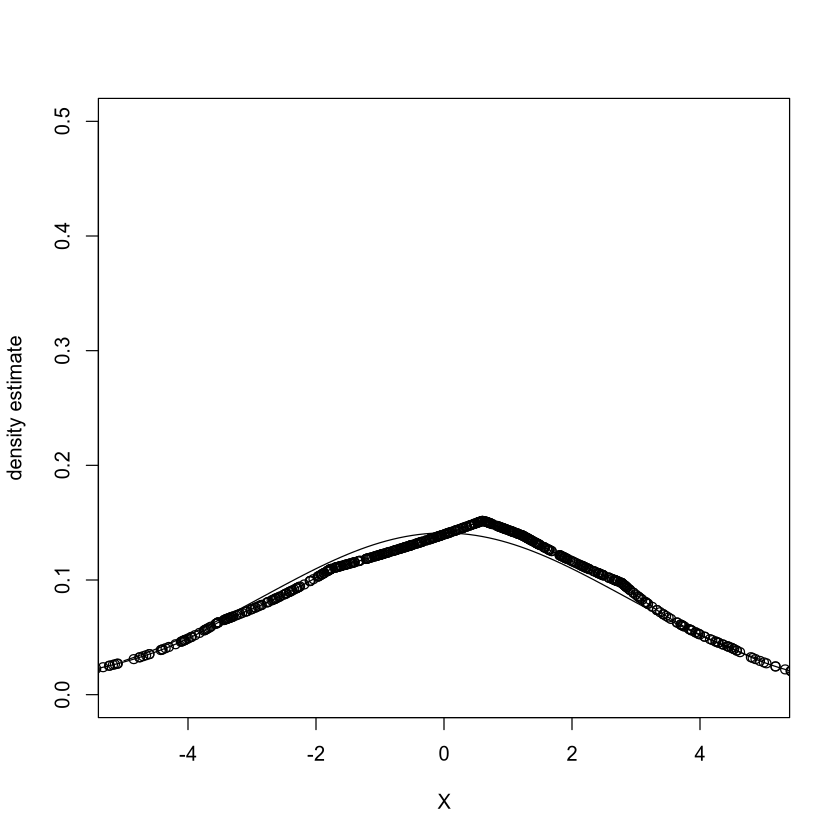

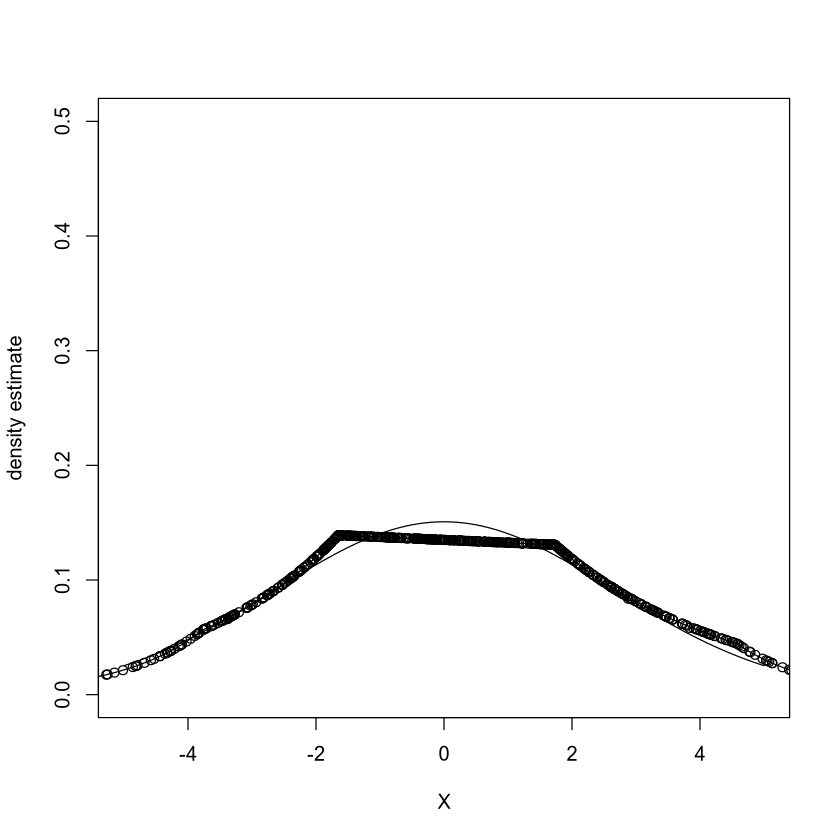

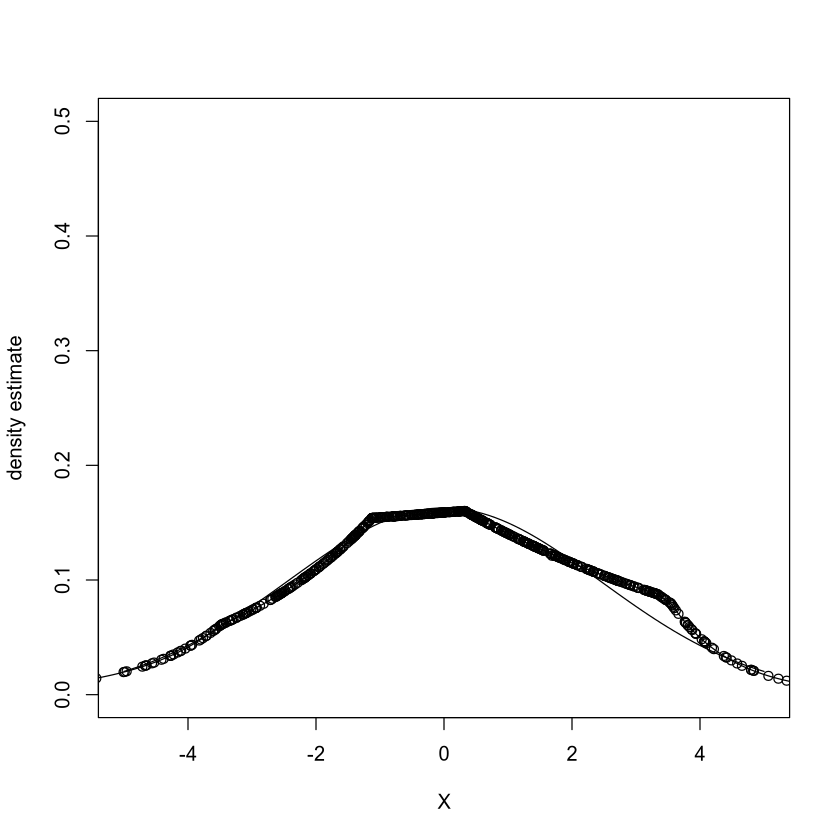

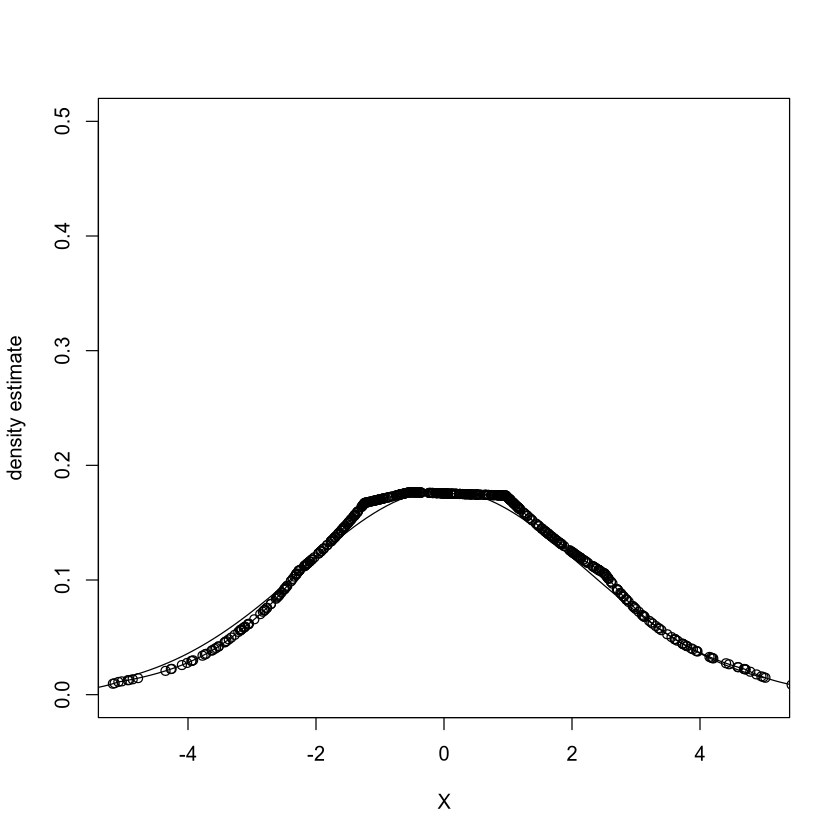

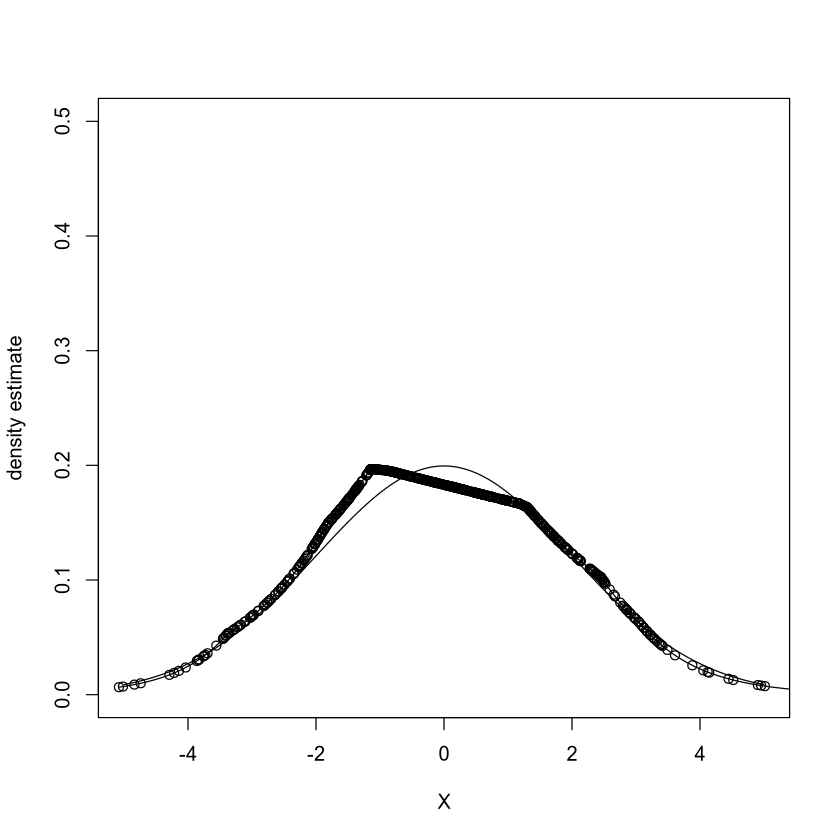

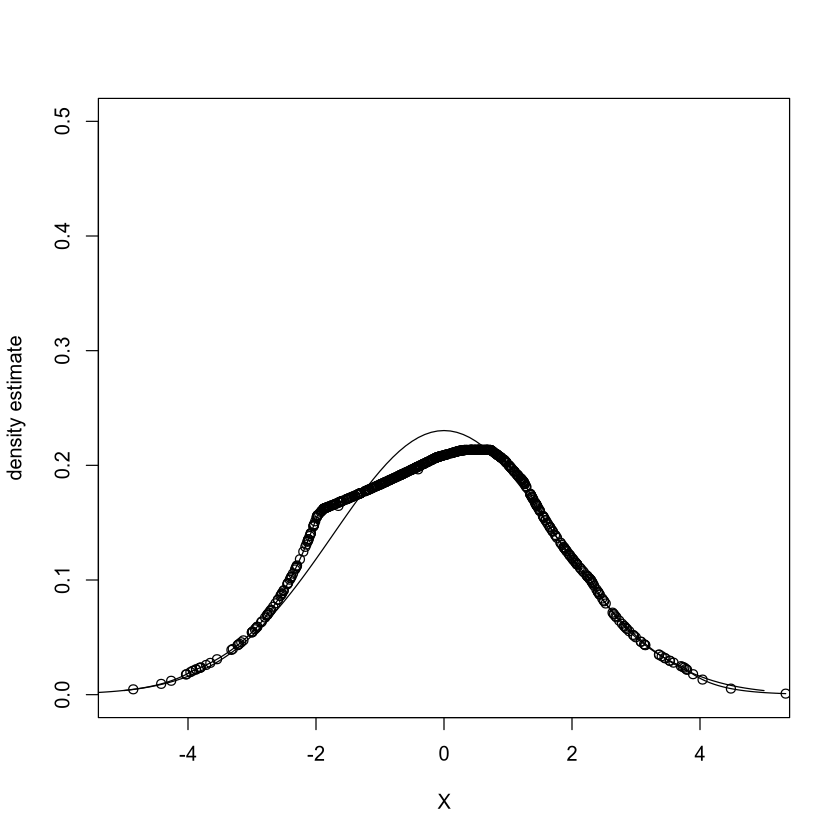

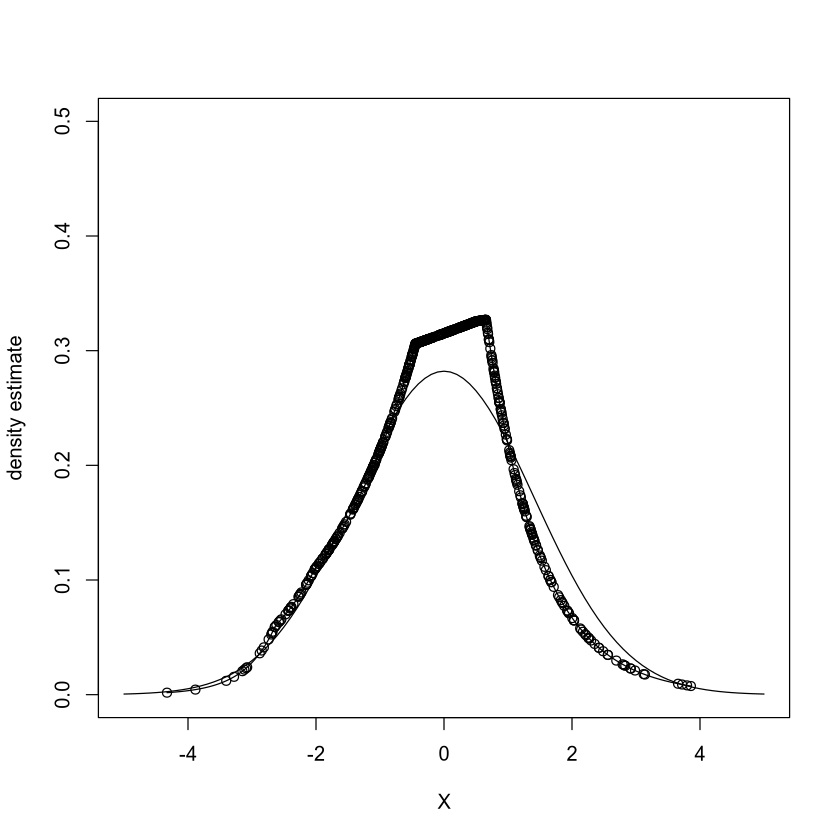

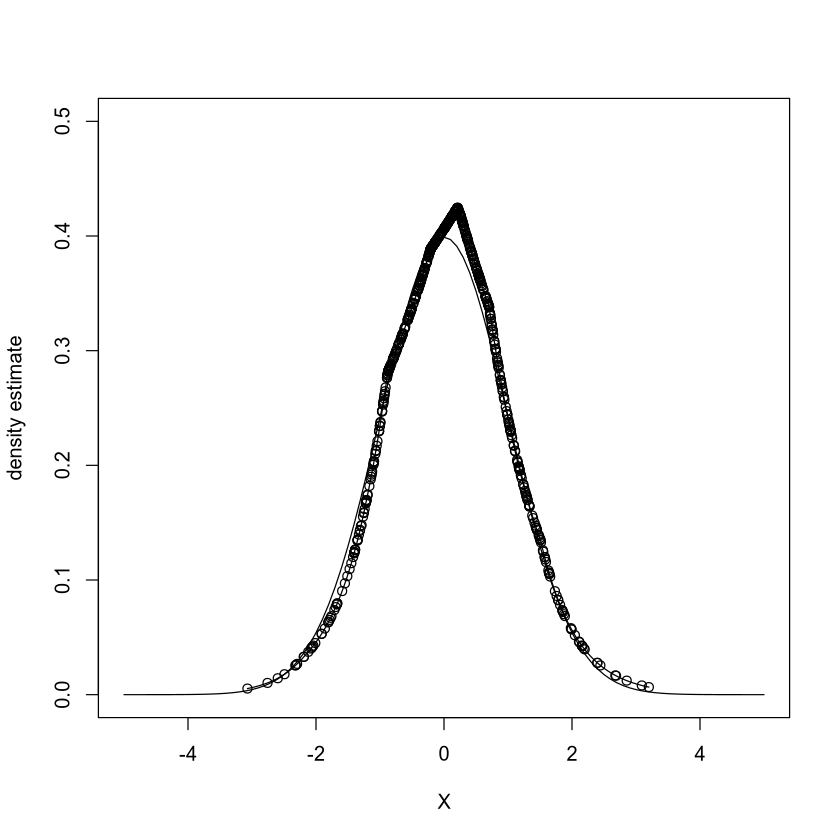

In [40]:
# names(marginals[[1]])
dimension = SimData$d
z <- seq(from=-5, to=5, by=0.1)
cov_comps = c(dimension:1)

for (ind in 1:d){
    plot(my_estimator$marginals[[ind]], xlim=c(-5,5), ylim=c(0,0.5))
    # plot(NULL, xlim=c(-5,5), ylim=c(0,3))
    lines(z, (2*pi*cov_comps[ind])^(-0.5) * exp(-0.5*z^2/cov_comps[ind]))

}


In [41]:
# Monte Carlo integration scheme

naive_monte_carlo_integrate <- function(F_fun, random_samples_generate, K_samps){
    # F_fun shoud take rows of a matrix as input points
    # Estimates int Fdp
    
    X_samps <- random_samples_generate(K_samps)
    F_samps <- F_fun(X_samps)
    return(mean(F_samps))
}

naive_monte_carlo_integrate_with_convergence <- function(F_fun, random_samples_generate, K_samps, step=100, ylim=c(0,0.3)){
    K_samp_range <- seq(step, K_samps, by=step)
    num_K_samps <- length(K_samp_range)
    all_F_means <- rep(NULL, num_K_samps)
    
    for (kind in 1:num_K_samps) {
        all_F_means[kind] <- naive_monte_carlo_integrate(F_fun, random_samples_generate, K_samp_range[kind])
    }
    plot(x=K_samp_range, y=all_F_means, type="b", ylim=ylim)
}

naive_monte_carlo_integrate_repeated <- function(F_fun, random_samples_generate, K_samps, num_repeats=100){
    all_F_estimates <- rep(NULL, num_repeats)
    for (rind in 1:num_repeats){
        all_F_estimates[rind] <- naive_monte_carlo_integrate(F_fun, random_samples_generate, K_samps)
    }
    return(list("mean_val"=mean(all_F_estimates), "median_val"=median(all_F_estimates), 
                "sd_val"=sd(all_F_estimates), "all_vals"=all_F_estimates))
}

In [129]:
median(c(1:10))

[1] 5.5

In [42]:
F_fun <- function(X_samps){
    density_ratio <- evaluate_estimator_vectorized(X_samps, my_estimator)/test_pdf_vectorized(X_samps, SimData)
    return(0.5*(sqrt(density_ratio)-1)^2)
}

random_samples_generate <- function(K_samps){
    return(mvrnorm(K_samps, mu=rep_len(0,d), Sigma=SimData$covariance_X))
}

In [116]:
K_samps = 10000
hellinger_error_estimate <- naive_monte_carlo_integrate(F_fun, random_samples_generate, K_samps)

In [117]:
hellinger_error_estimate

[1] 0.05782079

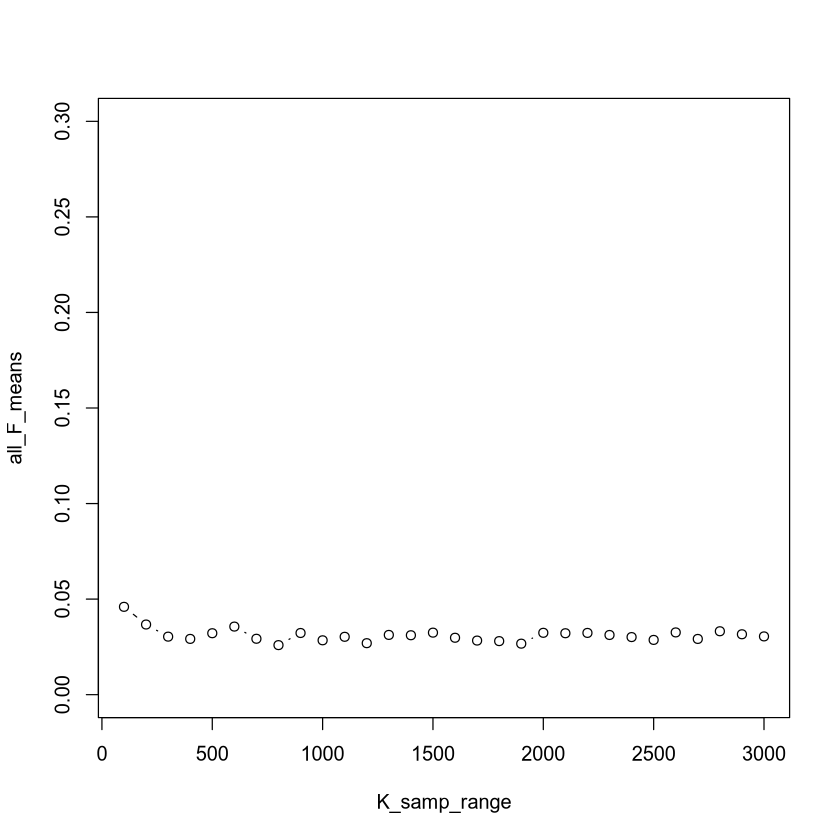

In [49]:
K_samps = 3000
naive_monte_carlo_integrate_with_convergence(F_fun, random_samples_generate, K_samps, step=100)

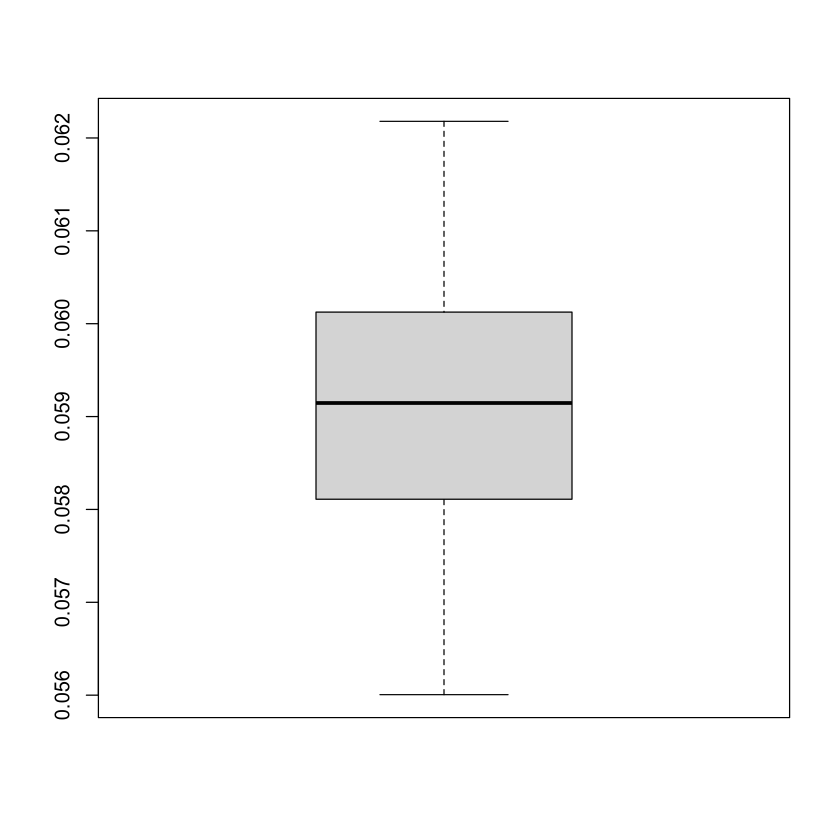

In [118]:
K_samps <- 10000
num_repeats <- 100
hellinger_error_estimate_statistics <- naive_monte_carlo_integrate_repeated(F_fun, random_samples_generate, K_samps, num_repeats)
boxplot(hellinger_error_estimate_statistics$all_vals)


In [119]:
hellinger_error_estimate_statistics$sd_val

[1] 0.00144776

In [121]:
# my_estimator$marginals

In [122]:

integrand <- function(x) {
      return (0.5 * (sqrt(gaussian_test_data_pdf(x, d, SimData$covariance_Z, W)) - sqrt(evaluate_estimator(x, my_estimator)))^2)
}
err <- 1e-5
adaptIntegrate(integrand, rep(-10, d), rep(10, d), absError = err)$integral


[1] 0.00518007

In [41]:
covariance_Z[-1,1]

[1] 0 0

In [35]:
my_mean = rep(0,dimension)
gtdvals = dmvnorm(SplitData$data_marginal_estimation, my_mean, SimData$covariance_X)


In [38]:
NROW(gtdvals)

[1] 300

In [109]:
source('lcic.r')

[1] "PCA done!"
[1] "Marginal: "
[1] 1
[1] "Marginal: "
[1] 2


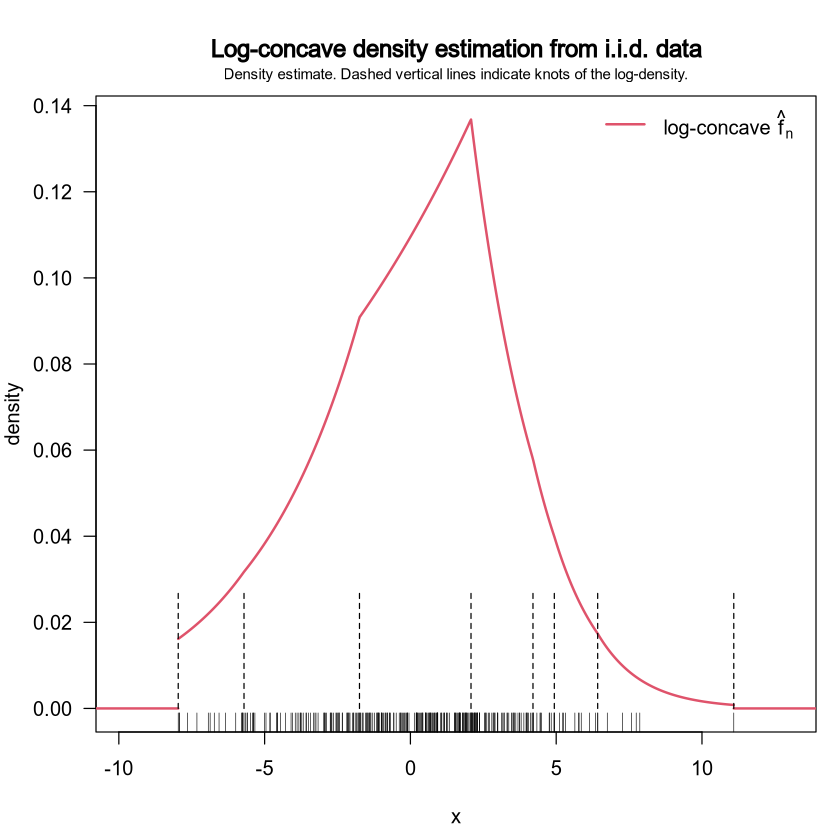

[1] "Marginal: "
[1] 3


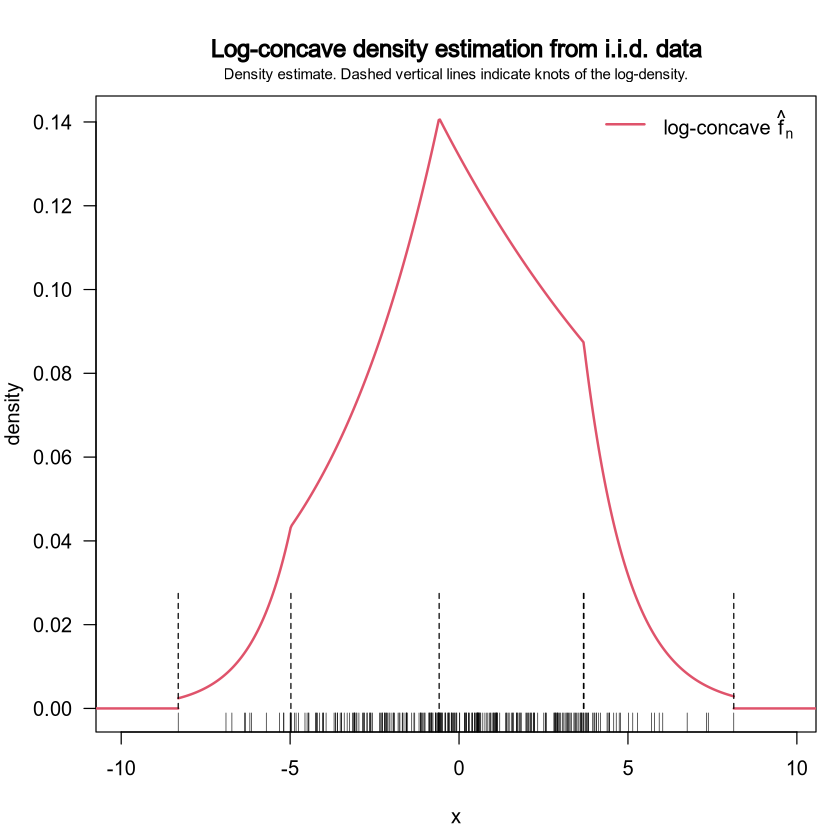

[1] "Marginal: "
[1] 4


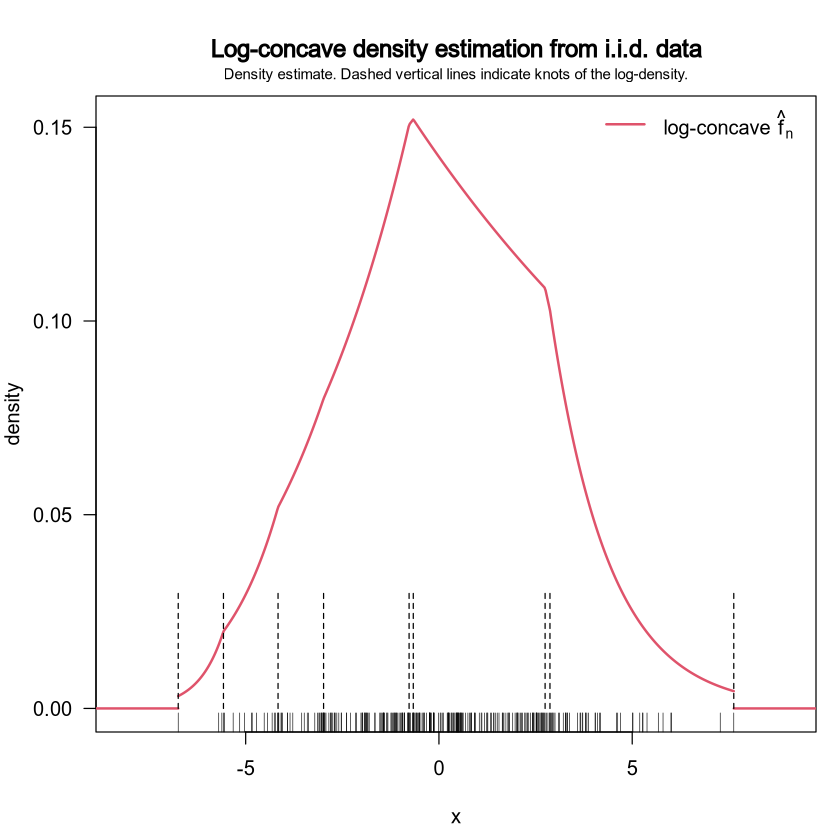

[1] "Marginal: "
[1] 5


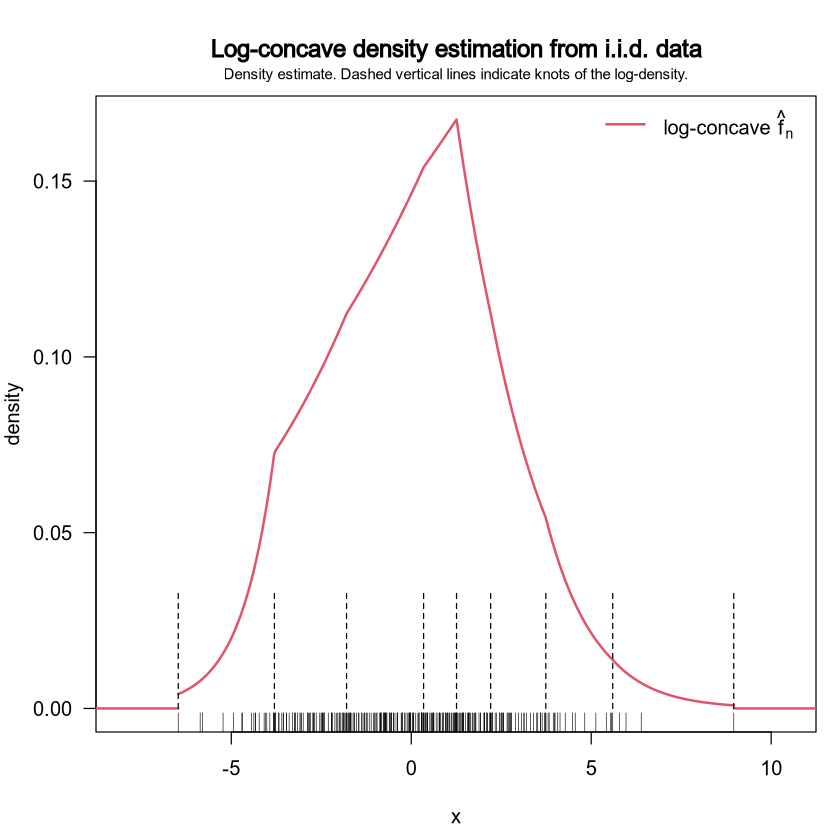

[1] "Marginal: "
[1] 6


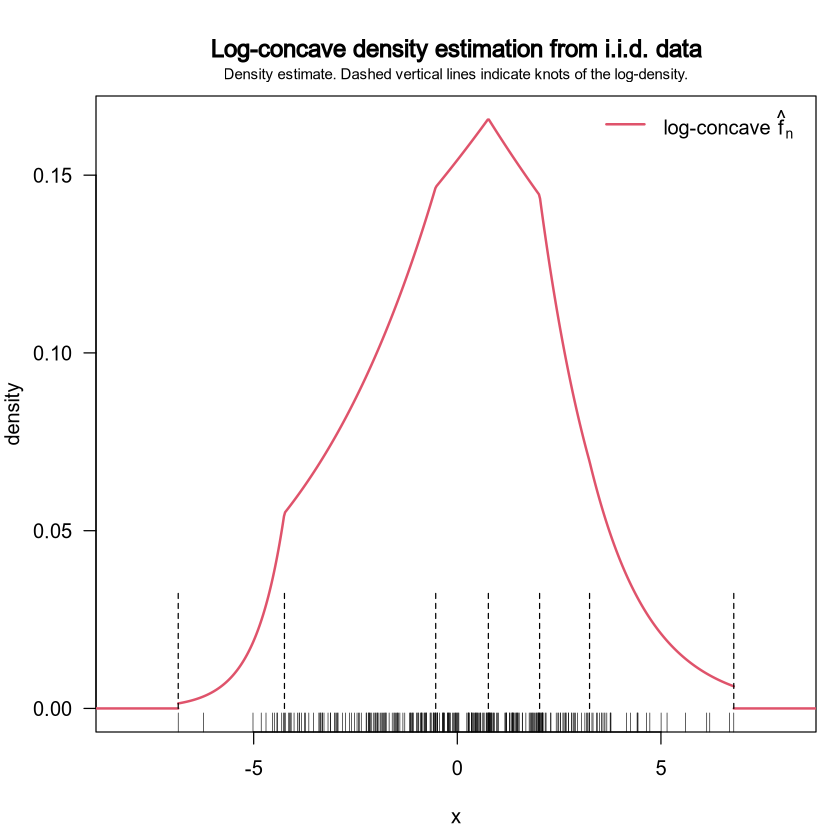

[1] "Marginal: "
[1] 7


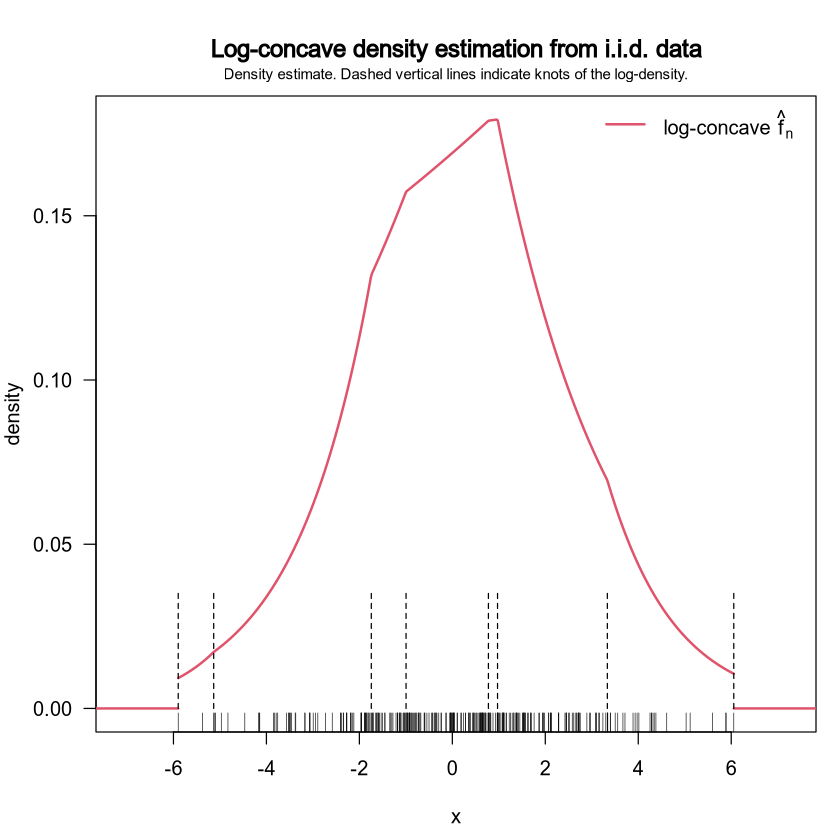

[1] "Marginal: "
[1] 8


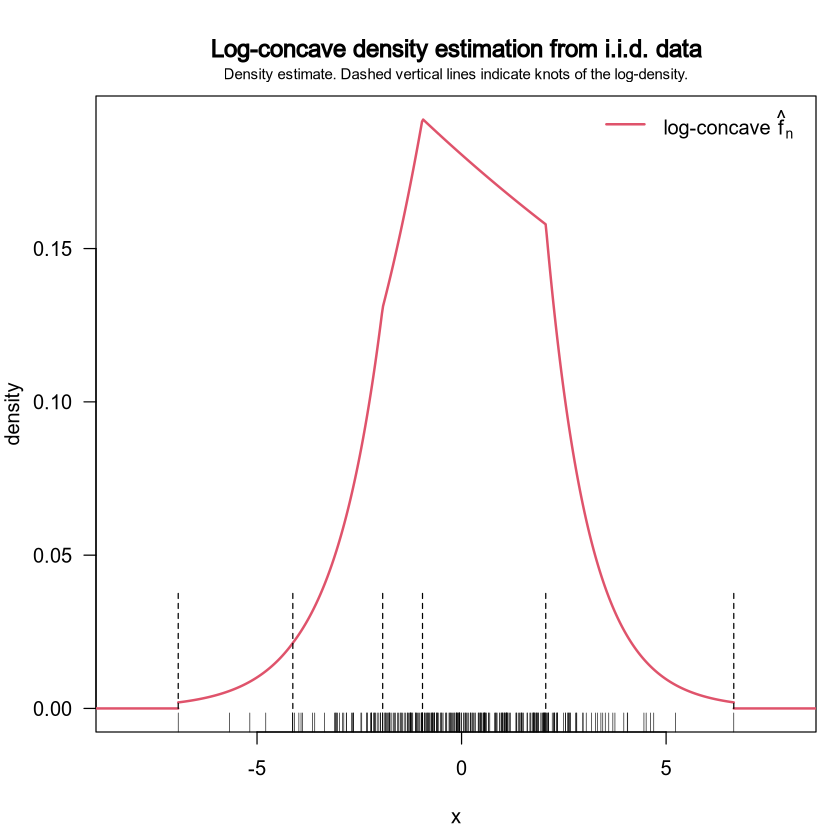

[1] "Marginal: "
[1] 9


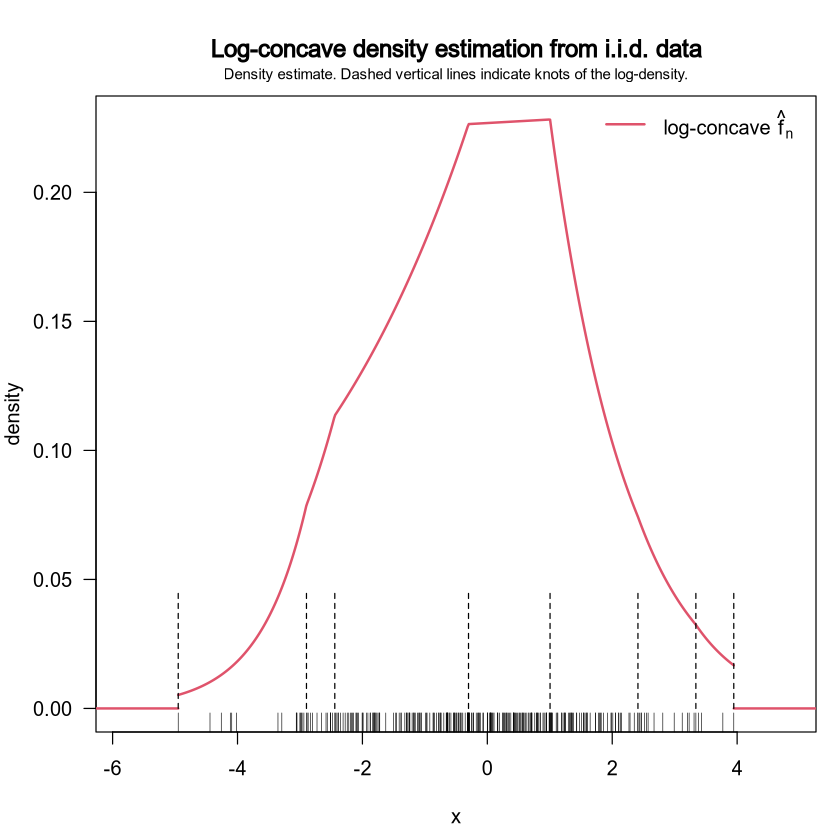

[1] "Marginal: "
[1] 10


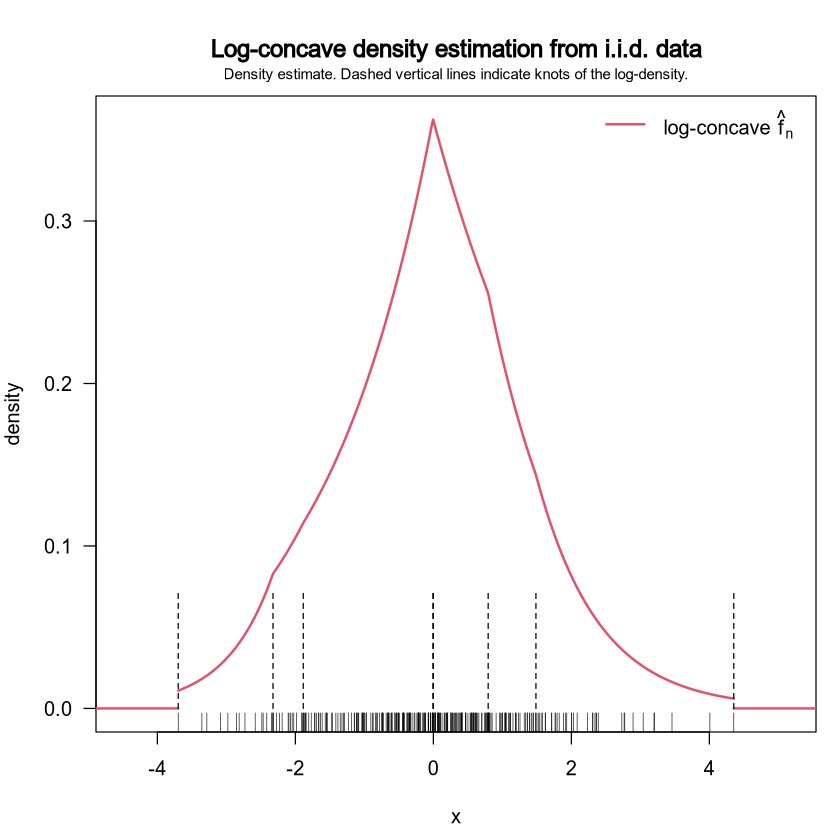

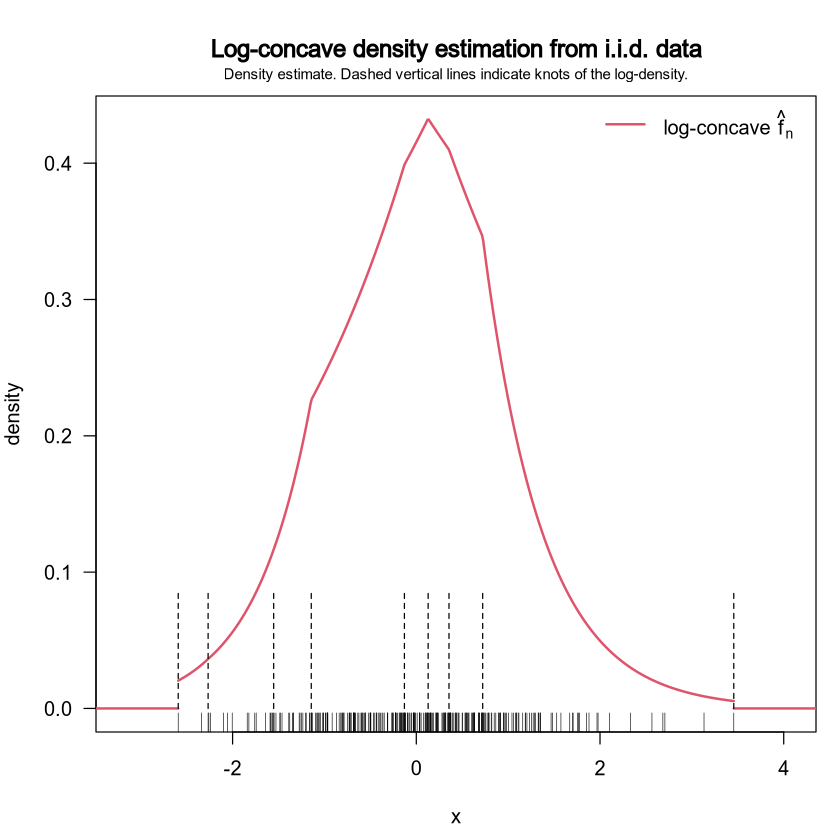

In [80]:
mynewestimator = generate_estimator_with_logcondens(SimData, r=0.9, plotting=TRUE)

In [81]:
F_new_fun <- function(X_samps){
    density_ratio <- evaluate_logcondens_estimator_vectorized(X_samps, mynewestimator)/heteroskedastic_gaussian_pdf_vectorized(X_samps, SimData)
    return(0.5*(sqrt(density_ratio)-1)^2)
}

In [112]:
K_samps = 10000
hellinger_error_estimate_new <- naive_monte_carlo_integrate(F_new_fun, random_samples_generate, K_samps)

In [115]:
hellinger_error_estimate_new

[1] 0.05708386

In [84]:
X_samps <- mvrnorm(K_samps, mu=rep_len(0,d), Sigma=SimData$covariance_X)

In [111]:
# evaluate_logcondens_estimator_vectorized(X_samps, mynewestimator)
# Z_mat_hat = X_samps %*% t(mynewestimator$W_hat)

In [105]:
size(Z_mat_hat)

[1] 10000    10

In [107]:
print(evaluateLogConDens(Z_mat_hat[,1], mynewestimator$marginals[[1]], which=2)[,3])

    [1] 0.0465144989 0.1152470469 0.1120098196 0.1098183112 0.0569634767
    [6] 0.0885643855 0.1028356378 0.0977158194 0.1026712631 0.0610561856
   [11] 0.1212050474 0.0662257603 0.0497537435 0.0027418792 0.0441185488
   [16] 0.0655240046 0.0605707479 0.0855984469 0.1271660553 0.1213185314
   [21] 0.0182838056 0.1071596505 0.0954527015 0.0977509407 0.0553700017
   [26] 0.0325674889 0.0516067655 0.1338564968 0.0649649279 0.0162589035
   [31] 0.1192543611 0.1248675831 0.1301597266 0.1174510856 0.1292656577
   [36] 0.1054259719 0.0393352749 0.0625533446 0.1208959369 0.1014465005
   [41] 0.1048144988 0.0954418241 0.1052712419 0.1306800734 0.0298530264
   [46] 0.1215990765 0.0679137392 0.0967663440 0.0100229658 0.1014855748
   [51] 0.0814359133 0.0841156865 0.1265494279 0.0665960694 0.1336870276
   [56] 0.0682065402 0.0944225839 0.1351747010 0.0944109391 0.0740906830
   [61] 0.1105494471 0.1018475082 0.1236967587 0.1242772576 0.1069843729
   [66] 0.1213827568 0.0362175274 0.0686909819 0.03

Comp.1,0.9976357108,0.0450462953,0.013090679,0.022878510,0.039293194,-0.015987858,0.012233791,-0.006666208,0.001872695,0.001360184
Comp.2,-0.0402229753,0.9580672067,-0.221307851,-0.138001178,0.099555039,0.047806355,-0.002833531,0.008974065,-0.006419099,-0.011892372
Comp.3,0.0238245647,-0.2398231903,-0.964231153,-0.068861990,0.054286435,0.053022643,-0.020127351,-0.033322155,-0.011658284,-0.004871112
Comp.4,-0.0271113125,0.1160242897,-0.099882458,0.986879780,0.020421278,-0.006388715,-0.019749472,0.023462018,0.022252664,0.001265750
Comp.5,-0.0391291774,-0.0770364755,0.062459897,-0.006343554,0.967881335,-0.222831573,-0.006385986,-0.044630347,0.004314986,0.009661890
Comp.6,0.0087816458,-0.0504049669,0.078291649,0.014450774,0.214456828,0.970087964,-0.061720732,0.001986868,0.009389639,-0.008936631
Comp.7,0.0120508883,0.0042571982,0.016834963,-0.018527311,-0.021087159,-0.059694409,-0.997397934,-0.003631541,0.009580281,0.017154483
Comp.8,-0.0067883067,0.0223325380,0.024343944,0.022961133,-0.043666870,0.010185868,0.004394471,-0.996063559,0.063871375,-0.009127428
Comp.9,0.0008638636,-0.0001725658,0.013316662,0.025184943,0.002546358,0.006966650,-0.010300984,-0.063017127,-0.997422243,-0.014289594
Comp.10,-0.0014854352,0.0104443916,-0.007003493,-0.002180147,-0.006069198,0.012901442,0.016397077,-0.009561360,-0.013962191,0.999538092


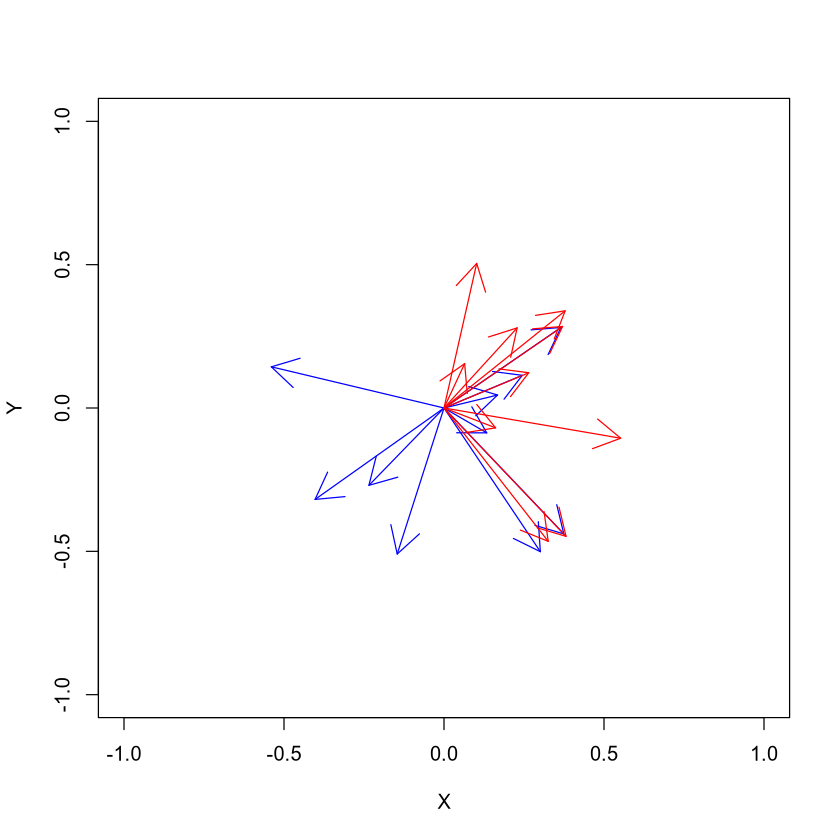

In [114]:
W = SimData$W
W_hat = mynewestimator$W_hat
plot(NULL, xlim=c(-1,1), ylim=c(-1,1), xlab="X", ylab="Y")
arrows(rep(0,d), rep(0,d), W[,1], W[,2], col="blue")
arrows(rep(0,d), rep(0,d), W_hat[,1], W_hat[,2], col="red")
W_hat %*% t(W)

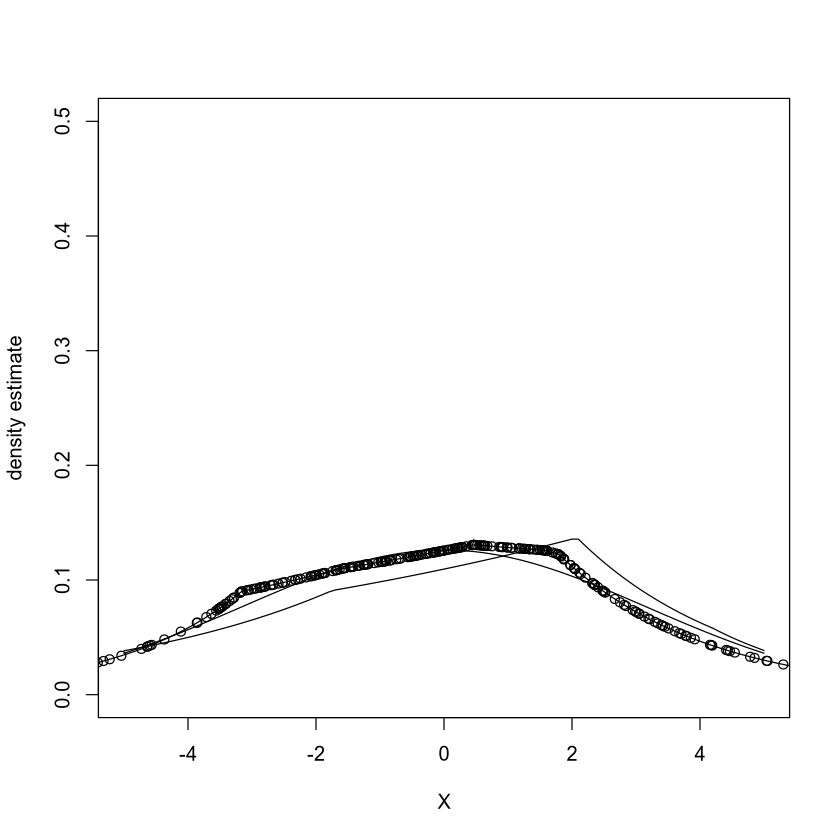

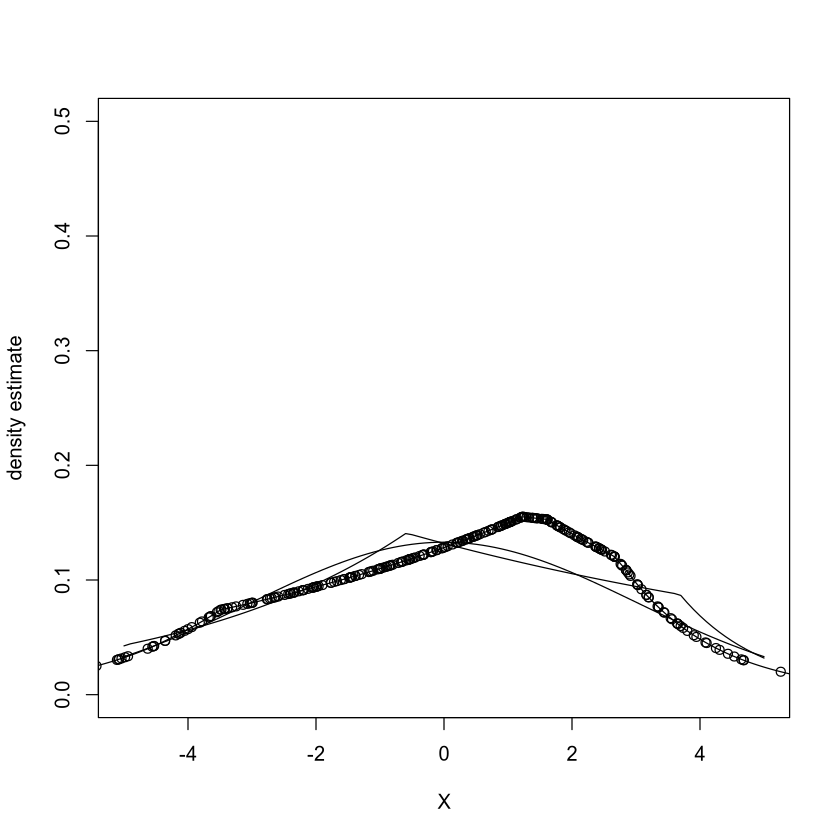

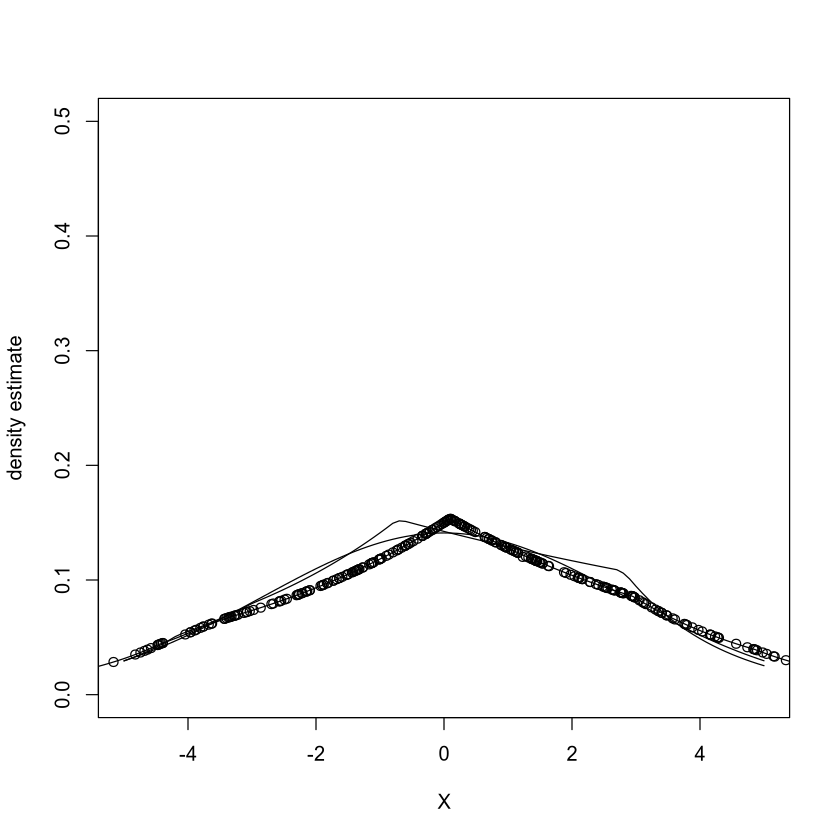

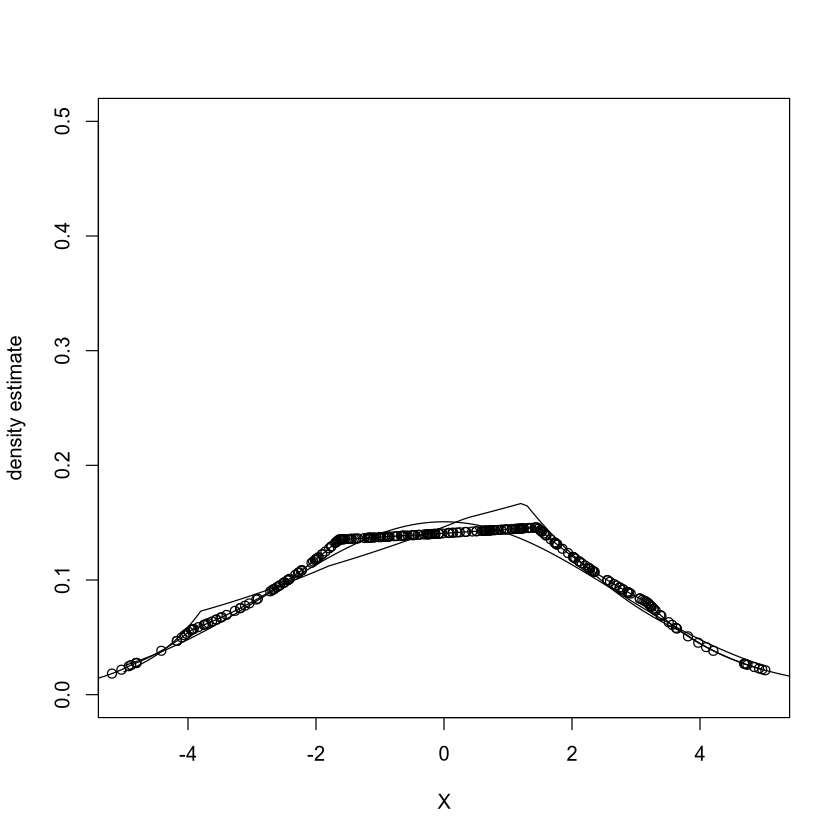

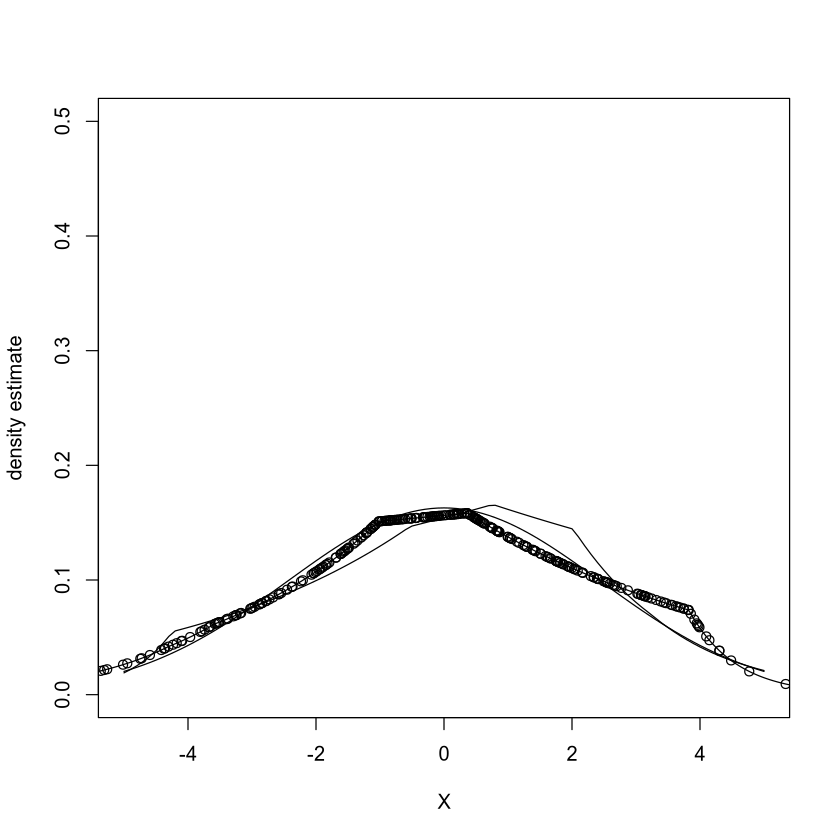

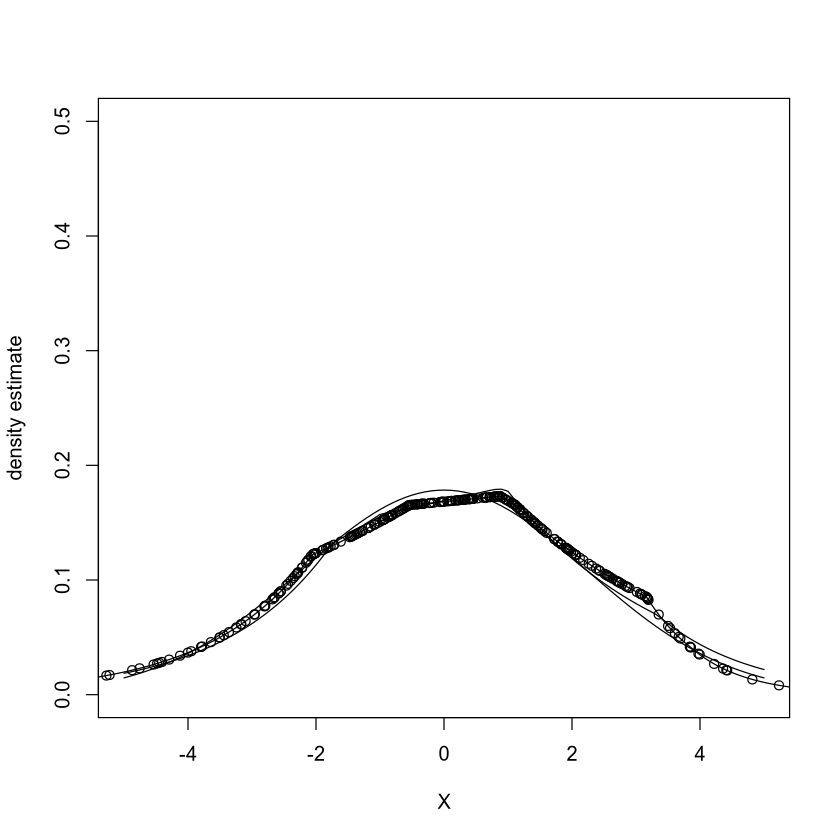

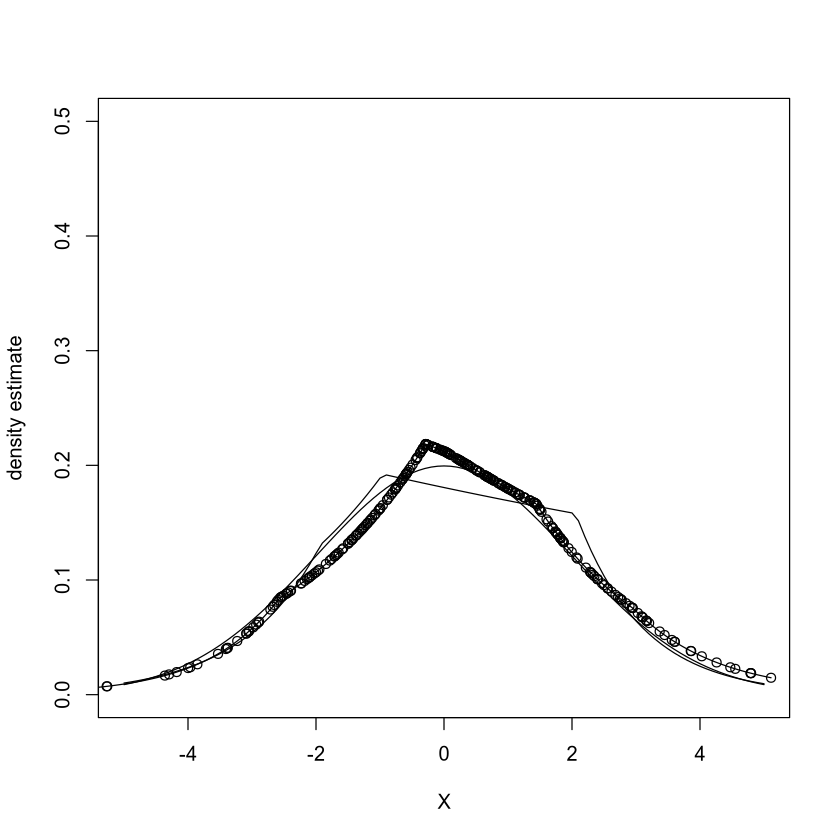

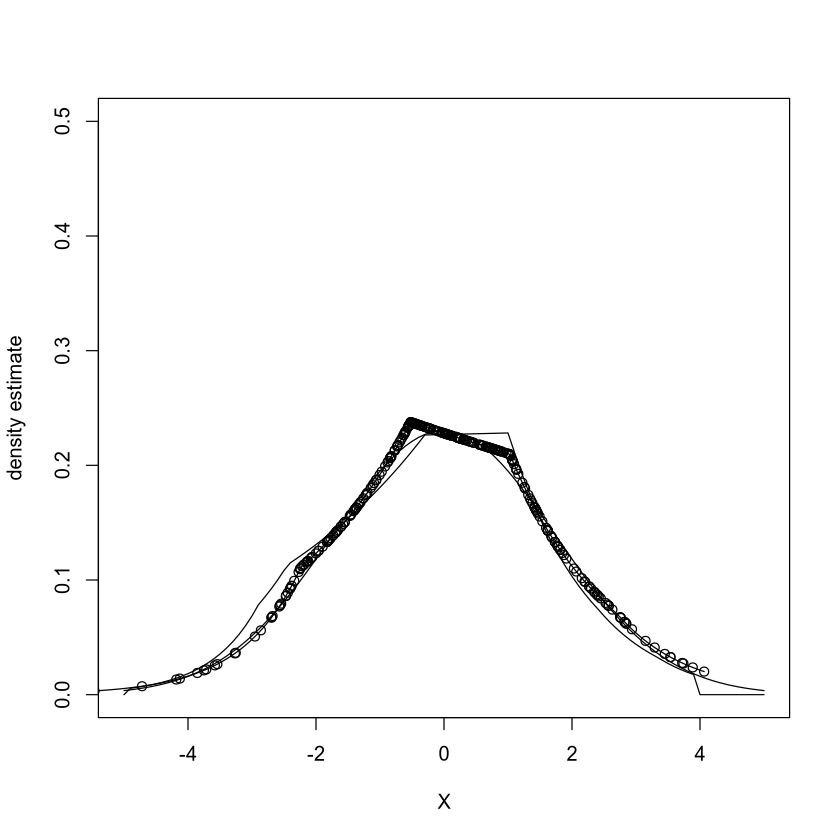

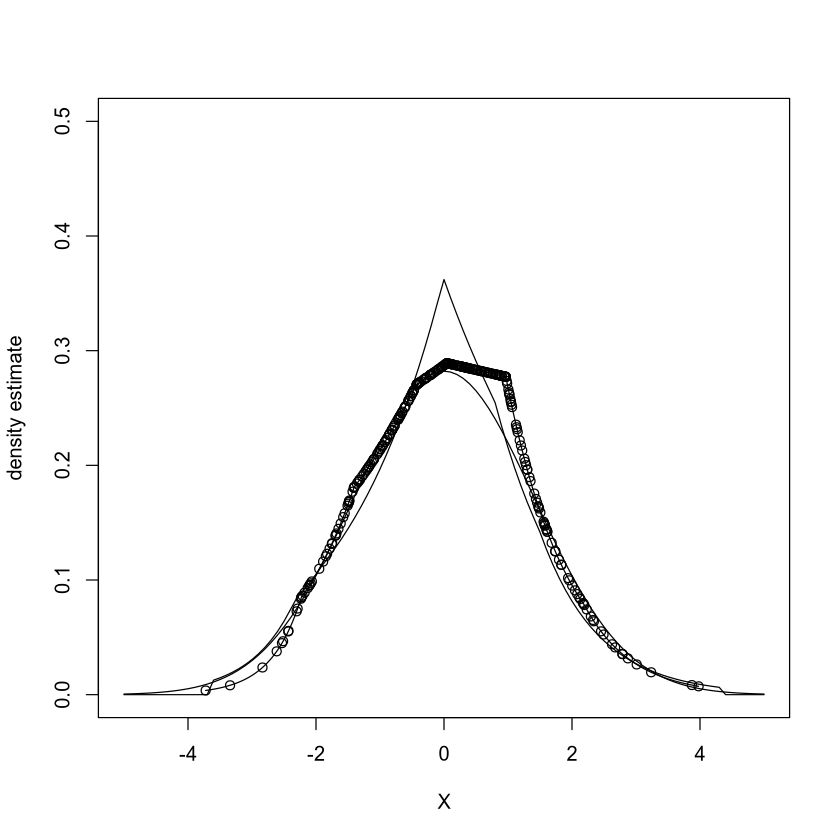

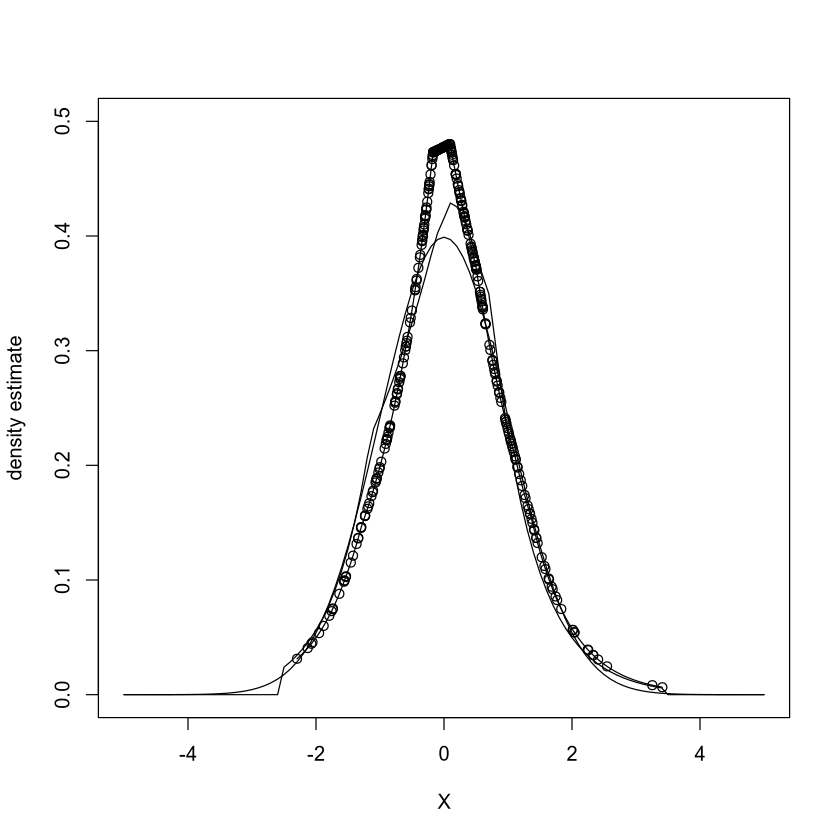

In [130]:
# names(marginals[[1]])
dimension = SimData$d
z <- seq(from=-5, to=5, by=0.1)
cov_comps = c(d:1)

for (ind in 1:d){
    plot(my_estimator$marginals[[ind]], xlim=c(-5,5), ylim=c(0,0.5))
    lines(z, evaluateLogConDens(z, mynewestimator$marginals[[ind]], which=2)[,3], xlim=c(-5,5), ylim=c(0,0.5))
    # plot(NULL, xlim=c(-5,5), ylim=c(0,3))
    lines(z, (2*pi*cov_comps[ind])^(-0.5) * exp(-0.5*z^2/cov_comps[ind]))

}


In [127]:
mynewestimator$marginals[[ind]]

$xn
  [1] -7.96317906 -7.93123751 -7.92586774 -7.64302763 -7.32168552 -6.93198252
  [7] -6.86878193 -6.72657392 -6.56288766 -6.33654206 -5.99024158 -5.78773062
 [13] -5.76911509 -5.75524808 -5.74384291 -5.70676827 -5.65722934 -5.60089856
 [19] -5.59445588 -5.47763951 -5.41763818 -5.38351911 -5.37511913 -5.33346983
 [25] -5.00534284 -4.95332510 -4.81988798 -4.80827836 -4.58633725 -4.56747733
 [31] -4.55377435 -4.45130549 -4.28532800 -4.09330615 -4.04216016 -3.94900749
 [37] -3.88725155 -3.82489533 -3.76787817 -3.76247389 -3.72595868 -3.67622937
 [43] -3.58069342 -3.55907958 -3.49438123 -3.43110080 -3.32280883 -3.27353054
 [49] -3.23896102 -3.16668182 -2.96917475 -2.95788518 -2.95092688 -2.90758106
 [55] -2.87930850 -2.74876264 -2.74817407 -2.69978249 -2.69262726 -2.64032639
 [61] -2.55328759 -2.53997117 -2.49220068 -2.47624868 -2.44523790 -2.44361731
 [67] -2.33795546 -2.33622950 -2.18041942 -2.16465140 -2.14137746 -2.13348506
 [73] -2.10475270 -2.07267248 -1.99222618 -1.95668440 -1.941

In [32]:
# SplitData$data_marginal_estimation
my_mean

0,0,0
0,0,0
0,0,0


In [66]:
mytestmat = matrix(c(1,-2,0,4,5,6), nrow=3)

In [67]:
mytestmat

1,4
-2,5
0,6


In [62]:
mytestmat * sign(mytestmat[,1])

1,4
2,-5
3,6


In [63]:
source('lcic.r')

In [68]:
fix_signs(mytestmat)

1,4
2,-5
0,6


In [72]:
mytestmat

1,4
-2,5
0,6


In [73]:
print(colMeans(fix_signs(mytestmat)))

[1] 1.000000 1.666667
